source: [link](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1)

### Autoencoder 
An autoencoder is a neural network that map features x to another representation of itself. In essen, the input features is passed into a encoder network and then the result is passed into a decoder network. This process: 
1. learns the data representation in lower-dimension space, i.e. a form of dimensionality reduction. 
2. <b>reconstruct</b> the original data based on the lower-dimension representation.

In [6]:
from torch import nn
import torch
import torchvision

In [3]:
# writing the encoder-decoder layers in one class
class AE(nn.Module): 
    def __init__(self, **kwargs) -> None: # kwargs pass all arguments in the construction
        """
        Constructor method, pass the configuration in as arguments
        """
        super().__init__()

        # encoder layers 
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128) # 1st hidden layer
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=128) # output layer 

        # decoder layers 
        self.decoder_hidden_layer = nn.Linear(in_features=128, out_features=128) # 1st hidden layer
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])

    def forward(self, features): 
        """
        Forward pass function, called every time given a feature input 
        """
        # each layer has two passing, one for the layer and one for the activation
        # pass input across the encoder layers 
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation) 
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        # pass output across the decoder layers
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [5]:
# setup the gpu, initialize the model, optimizer, and loss function 
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# create model 
model = AE(input_shape=784).to(device)

# create an optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# specify MSE
criterion = nn.MSELoss()

In [8]:
# use MNIST digits dataset from torchvision
# transform the images to Tensor objects 
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download the train, test datasets
train_data = torchvision.datasets.MNIST(
    root='../data/raw/torch_datasets', 
    train=True,
    transform=transform,
    download=True, 
) 
test_data = torchvision.datasets.MNIST(
    root='../data/raw/torch_datasets', 
    train=False,
    transform=transform,
    download=True, 
) 

# create train, test dataloader 
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=128, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32, 
    shuffle=False, 
    num_workers=4, 
)

In [9]:
# training process
epochs = 50
for epoch in range(epochs): 
    loss = 0 
    for batch_features, _ in train_loader: 
        # reshape batch data [N, 784] (flatten it) and load it to the device
        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero for each batch
        optimizer.zero_grad()

        # compute reconstruction with model 
        outputs = model(batch_features)

        # compute training reconstruction loss (MSE)
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients 
        train_loss.backward()

        # perform parameter update based on current gradients 
        optimizer.step()

        # add the mini-batch training loss to epoch loss 
        loss += train_loss.item()

    # compute the epoch training loss 
    loss /= len(train_loader)
    # display the epoch training loss 
    print(f"epoch : {epoch+1}/{epochs}, loss = {loss:.6f}")

epoch : 1/50, loss = 0.033165
epoch : 2/50, loss = 0.018559
epoch : 3/50, loss = 0.016618
epoch : 4/50, loss = 0.015657
epoch : 5/50, loss = 0.015069
epoch : 6/50, loss = 0.014664
epoch : 7/50, loss = 0.014351
epoch : 8/50, loss = 0.014086
epoch : 9/50, loss = 0.013868
epoch : 10/50, loss = 0.013685
epoch : 11/50, loss = 0.013271
epoch : 12/50, loss = 0.012867
epoch : 13/50, loss = 0.012696
epoch : 14/50, loss = 0.012572
epoch : 15/50, loss = 0.012486
epoch : 16/50, loss = 0.012378
epoch : 17/50, loss = 0.012308
epoch : 18/50, loss = 0.012233
epoch : 19/50, loss = 0.012163
epoch : 20/50, loss = 0.012099
epoch : 21/50, loss = 0.012049
epoch : 22/50, loss = 0.011999
epoch : 23/50, loss = 0.011950
epoch : 24/50, loss = 0.011908
epoch : 25/50, loss = 0.011870
epoch : 26/50, loss = 0.011839
epoch : 27/50, loss = 0.011795
epoch : 28/50, loss = 0.011777
epoch : 29/50, loss = 0.011742
epoch : 30/50, loss = 0.011720
epoch : 31/50, loss = 0.011692
epoch : 32/50, loss = 0.011670
epoch : 33/50, lo

In [30]:
# plot the first 10 
image_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=10, 
    shuffle=False, 
    num_workers=4, 
)
images, labels = next(iter(image_loader))
images.shape

torch.Size([10, 1, 28, 28])

In [31]:
# get reconstruction of the same 10 images 
input_features = images.view(-1, 784).to(device)

# turn off gradient descent (no training, only reconstruction)
with torch.no_grad(): 
    output_features = model(input_features)
reconstruction = output_features.reshape(10, 28, 28)
reconstruction = reconstruction.cpu().numpy()
print(reconstruction[0].shape)

# translate the images to numpy array for plotting 
images = images.cpu().numpy()
print(images[0][0].shape)

(28, 28)
(28, 28)


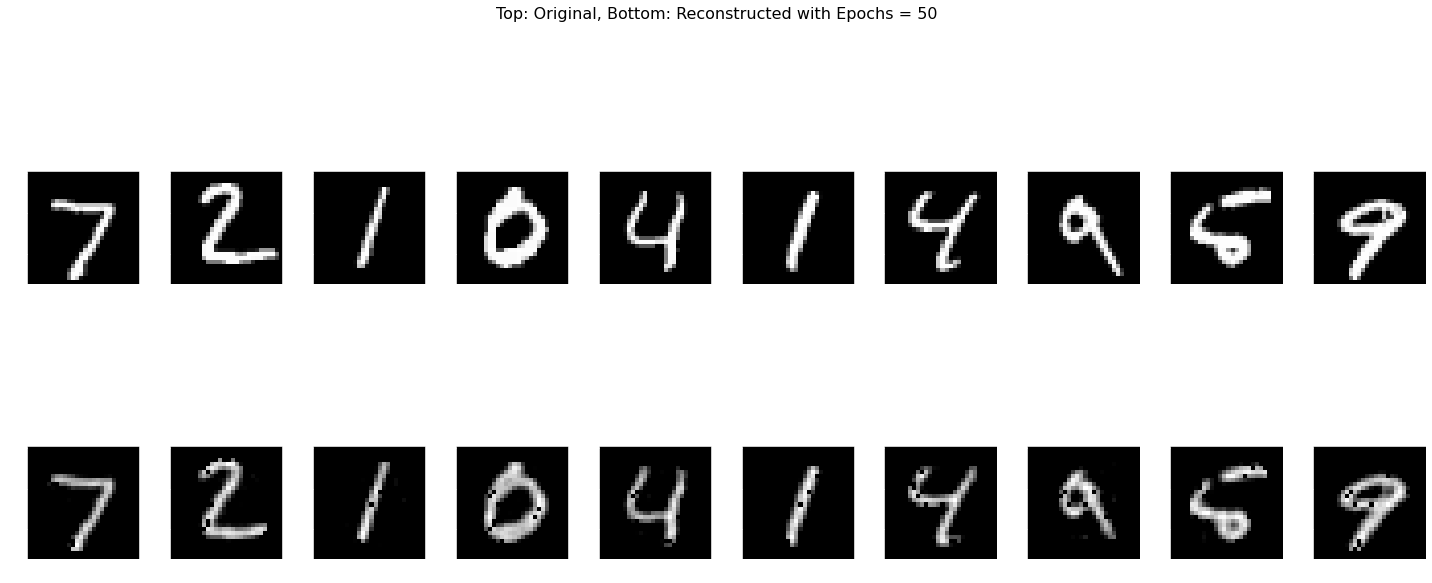

In [36]:
# plot the original vs the results 
import matplotlib.pyplot as plt 

original_img, reconstruct_img = images[:, 0, :, :], reconstruction

fig, axes = plt.subplots(2, 10, figsize=(20,10)) # 2 rows 10 columns 
fig.set_facecolor('white')
fig.suptitle("Top: Original, Bottom: Reconstructed with Epochs = 50", fontsize=16, color='black')

for i in range(10): 
    ax_original = axes[0, i]
    ax_reconstruct = axes[1, i]

    ax_original.imshow(original_img[i], cmap='gray')
    ax_reconstruct.imshow(reconstruct_img[i], cmap='gray')

plt.tight_layout()
plt.show()


In [37]:
# evaluate the testing MSE of the original autoencoder 
loss = 0
with torch.no_grad(): 
    for batch_features, _ in test_loader: 
        # reshape batch data [N, 784] (flatten it) and load it to the device
        batch_features = batch_features.view(-1, 784).to(device)

        # compute reconstruction with model 
        outputs = model(batch_features)

        # compute training reconstruction loss (MSE)
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss 
        loss += test_loss.item()
        
print(f"The MSE of the original Autoencoder setup with 1 hidden layer is {loss}")

The MSE of the original Autoencoder setup with 1 hidden layer is 3.6000256603583694


#### Now let's try adding another hidden layer for both encoder and decoder

In [40]:
# increase the number of hidden layers by 1, now we have 2 hidden layers in total
class AE_v2(nn.Module): 
    def __init__(self, **kwargs) -> None: # kwargs pass all arguments in the construction
        """
        Constructor method, pass the configuration in as arguments
        """
        super().__init__()

        # encoder layers 
        self.encoder_hidden_layer_1 = nn.Linear(in_features=kwargs["input_shape"], out_features=256) # 1st hidden layer
        self.encoder_hidden_layer_2 = nn.Linear(in_features=256, out_features=128) # 2nd hidden layer
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=128) # output layer 

        # decoder layers 
        self.decoder_hidden_layer_1 = nn.Linear(in_features=128, out_features=128) # 1st hidden layer
        self.decoder_hidden_layer_2 = nn.Linear(in_features=128, out_features=256) # 2nd hidden layer
        self.decoder_output_layer = nn.Linear(in_features=256, out_features=kwargs["input_shape"])

    def forward(self, features): 
        """
        Forward pass function, called every time given a feature input 
        """
        # each layer has two passing, one for the layer and one for the activation
        # pass input across the encoder layers 
        activation = self.encoder_hidden_layer_1(features)
        activation = torch.relu(activation) 
        activation = self.encoder_hidden_layer_2(activation)
        activation = torch.relu(activation) 
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)

        # pass output across the decoder layers
        activation = self.decoder_hidden_layer_1(code)
        activation = torch.relu(activation)
        activation = self.decoder_hidden_layer_2(activation)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [41]:
# setup the gpu, initialize the model, optimizer, and loss function 
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# create model 
model = AE_v2(input_shape=784).to(device)

# create an optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# specify MSE
criterion = nn.MSELoss()

# use MNIST digits dataset from torchvision
# transform the images to Tensor objects 
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download the train, test datasets
train_data = torchvision.datasets.MNIST(
    root='../data/raw/torch_datasets', 
    train=True,
    transform=transform,
    download=True, 
) 
test_data = torchvision.datasets.MNIST(
    root='../data/raw/torch_datasets', 
    train=False,
    transform=transform,
    download=True, 
) 

# create train, test dataloader 
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=128, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32, 
    shuffle=False, 
    num_workers=4, 
)

In [42]:
# training process
epochs = 50
for epoch in range(epochs): 
    loss = 0 
    for batch_features, _ in train_loader: 
        # reshape batch data [N, 784] (flatten it) and load it to the device
        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero for each batch
        optimizer.zero_grad()

        # compute reconstruction with model 
        outputs = model(batch_features)

        # compute training reconstruction loss (MSE)
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients 
        train_loss.backward()

        # perform parameter update based on current gradients 
        optimizer.step()

        # add the mini-batch training loss to epoch loss 
        loss += train_loss.item()

    # compute the epoch training loss 
    loss /= len(train_loader)
    # display the epoch training loss 
    print(f"epoch : {epoch+1}/{epochs}, loss = {loss:.6f}")

epoch : 1/50, loss = 0.041231
epoch : 2/50, loss = 0.022489
epoch : 3/50, loss = 0.018806
epoch : 4/50, loss = 0.017085
epoch : 5/50, loss = 0.016056
epoch : 6/50, loss = 0.015251
epoch : 7/50, loss = 0.014643
epoch : 8/50, loss = 0.014172
epoch : 9/50, loss = 0.013811
epoch : 10/50, loss = 0.013498
epoch : 11/50, loss = 0.013252
epoch : 12/50, loss = 0.013010
epoch : 13/50, loss = 0.012828
epoch : 14/50, loss = 0.012647
epoch : 15/50, loss = 0.012516
epoch : 16/50, loss = 0.012365
epoch : 17/50, loss = 0.012241
epoch : 18/50, loss = 0.012113
epoch : 19/50, loss = 0.011997
epoch : 20/50, loss = 0.011915
epoch : 21/50, loss = 0.011790
epoch : 22/50, loss = 0.011706
epoch : 23/50, loss = 0.011637
epoch : 24/50, loss = 0.011557
epoch : 25/50, loss = 0.011484
epoch : 26/50, loss = 0.011446
epoch : 27/50, loss = 0.011371
epoch : 28/50, loss = 0.011327
epoch : 29/50, loss = 0.011286
epoch : 30/50, loss = 0.011229
epoch : 31/50, loss = 0.011209
epoch : 32/50, loss = 0.011165
epoch : 33/50, lo

In [43]:
# evaluate the testing MSE of the new autoencoder with an extra layer
loss = 0
with torch.no_grad(): 
    for batch_features, _ in test_loader: 
        # reshape batch data [N, 784] (flatten it) and load it to the device
        batch_features = batch_features.view(-1, 784).to(device)

        # compute reconstruction with model 
        outputs = model(batch_features)

        # compute training reconstruction loss (MSE)
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss 
        loss += test_loss.item()
        
print(f"The MSE of the new Autoencoder setup with 2 hidden layers is {loss}")

The MSE of the new Autoencoder setup with 2 hidden layers is 3.306469895876944


#### Now let's try decrease the final dimension for the autoencoder

In [44]:
# decrease the final encoding dimension 
class AE_v3(nn.Module): 
    def __init__(self, **kwargs) -> None: # kwargs pass all arguments in the construction
        """
        Constructor method, pass the configuration in as arguments
        """
        super().__init__()

        # encoder layers 
        self.encoder_hidden_layer_1 = nn.Linear(in_features=kwargs["input_shape"], out_features=128) # 1st hidden layer
        self.encoder_hidden_layer_2 = nn.Linear(in_features=128, out_features=64) # 2nd hidden layer
        self.encoder_output_layer = nn.Linear(in_features=64, out_features=64) # output layer 

        # decoder layers 
        self.decoder_hidden_layer_1 = nn.Linear(in_features=64, out_features=64) # 1st hidden layer
        self.decoder_hidden_layer_2 = nn.Linear(in_features=64, out_features=128) # 2nd hidden layer
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])

    def forward(self, features): 
        """
        Forward pass function, called every time given a feature input 
        """
        # each layer has two passing, one for the layer and one for the activation
        # pass input across the encoder layers 
        activation = self.encoder_hidden_layer_1(features)
        activation = torch.relu(activation) 
        activation = self.encoder_hidden_layer_2(activation)
        activation = torch.relu(activation) 
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)

        # pass output across the decoder layers
        activation = self.decoder_hidden_layer_1(code)
        activation = torch.relu(activation)
        activation = self.decoder_hidden_layer_2(activation)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [45]:
# setup the gpu, initialize the model, optimizer, and loss function 
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# create model 
model = AE_v3(input_shape=784).to(device)

# create an optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# specify MSE
criterion = nn.MSELoss()

# use MNIST digits dataset from torchvision
# transform the images to Tensor objects 
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download the train, test datasets
train_data = torchvision.datasets.MNIST(
    root='../data/raw/torch_datasets', 
    train=True,
    transform=transform,
    download=True, 
) 
test_data = torchvision.datasets.MNIST(
    root='../data/raw/torch_datasets', 
    train=False,
    transform=transform,
    download=True, 
) 

# create train, test dataloader 
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=128, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=32, 
    shuffle=False, 
    num_workers=4, 
)

In [46]:
# training process
epochs = 50
for epoch in range(epochs): 
    loss = 0 
    for batch_features, _ in train_loader: 
        # reshape batch data [N, 784] (flatten it) and load it to the device
        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero for each batch
        optimizer.zero_grad()

        # compute reconstruction with model 
        outputs = model(batch_features)

        # compute training reconstruction loss (MSE)
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients 
        train_loss.backward()

        # perform parameter update based on current gradients 
        optimizer.step()

        # add the mini-batch training loss to epoch loss 
        loss += train_loss.item()

    # compute the epoch training loss 
    loss /= len(train_loader)
    # display the epoch training loss 
    print(f"epoch : {epoch+1}/{epochs}, loss = {loss:.6f}")

epoch : 1/50, loss = 0.047063
epoch : 2/50, loss = 0.026183
epoch : 3/50, loss = 0.022053
epoch : 4/50, loss = 0.020127
epoch : 5/50, loss = 0.019006
epoch : 6/50, loss = 0.018189
epoch : 7/50, loss = 0.017432
epoch : 8/50, loss = 0.016779
epoch : 9/50, loss = 0.016270
epoch : 10/50, loss = 0.015748
epoch : 11/50, loss = 0.015363
epoch : 12/50, loss = 0.015065
epoch : 13/50, loss = 0.014824
epoch : 14/50, loss = 0.014581
epoch : 15/50, loss = 0.014358
epoch : 16/50, loss = 0.014140
epoch : 17/50, loss = 0.013986
epoch : 18/50, loss = 0.013783
epoch : 19/50, loss = 0.013623
epoch : 20/50, loss = 0.013485
epoch : 21/50, loss = 0.013333
epoch : 22/50, loss = 0.013211
epoch : 23/50, loss = 0.013119
epoch : 24/50, loss = 0.013019
epoch : 25/50, loss = 0.012947
epoch : 26/50, loss = 0.012874
epoch : 27/50, loss = 0.012802
epoch : 28/50, loss = 0.012728
epoch : 29/50, loss = 0.012664
epoch : 30/50, loss = 0.012601
epoch : 31/50, loss = 0.012576
epoch : 32/50, loss = 0.012490
epoch : 33/50, lo

In [47]:
# evaluate the testing MSE of the new autoencoder with an extra layer
loss = 0
with torch.no_grad(): 
    for batch_features, _ in test_loader: 
        # reshape batch data [N, 784] (flatten it) and load it to the device
        batch_features = batch_features.view(-1, 784).to(device)

        # compute reconstruction with model 
        outputs = model(batch_features)

        # compute training reconstruction loss (MSE)
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss 
        loss += test_loss.item()
        
print(f"The MSE of the new Autoencoder setup with 2 hidden layers and lower final encoding dimension is {loss}")

The MSE of the new Autoencoder setup with 2 hidden layers and lower final encoding dimension is 3.6505118454806507
